# LDA Topic Modeling

In this notebook we will use LDA models optimized for coherence to review the topics present in the rmt corpus.

We will train a [latent dirichlet allocation model (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
) to discover topics in the data. LDA is a type of natural language processing model that gets topics from the corpus. You must specify the number of topics you want to extract, we iterate over different quantities of topics for each corpus and, later, use coherence analysis to select the best number of topic in the range. 
We will use `gensim`'s built in functionality to train the model. LDA models require a given number of topics to be specified. We will train models for different numbers of topics. Later on we will select between these models using topic coherence as our crtieria. 

A lot of the code in this section was pulled from the [topic_coherence_model_selection notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb) in the gensim repo. 

In [6]:
import os
import numpy as np
import pandas as pd

from student_voices import sv_utils as bn

## Setting Experimental Parameters 

Just as we did in the cleaning steps, there are certain things we will want to vary to retrieve the optimal results. The version of cleaned data is one of them, here are all the experimental parameters we will vary: 

* Data configuration: of our cleaning steps, two (A1, B1, D1 & E1) are suited for LDA analysis.
* Review length: very short reviews are less likely to convey valuable information, in the following cell block we will check review length distribution to set the values for this parameter. 
* Number of topics: LDA requires that we submit a number of topics before hand, we do not know how many topics can be found in each corpus so we will iterate through an array of these and select the best later.  
* Passes: number of passes to make over the corpus (akin to epochs or iterations)
* N-below: exclude words that occur fewer than this number of times (will be unable to extract meaning from too few contexts)
* N-above: exclude words that occure in over this percentage of reviews (will be unable to extract meaning from too many contexts). 

**Selecting a Target**

Besides these parameters there is one other item to decide which is the target of our analysis. We have generated two general sets of indices, reviews in certain ranges, and reviews with certain characteristic lables. Either can be used in LDA (unsupervised) or supervised learning contexts. 

Our goal is to identify the profiles of bad teaching and use good reviews to contrast and contextualize these. We will assume that longer reviews contain more information, thus we will vary the input to our LDA models based on review length. Below we examine the statistics around review length and decide exactly what we want to target. 

In [13]:
%%time 

root_dir = 'C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices/student_voices/'

# import the data if need be
data = bn.decompress_pickle(root_dir+'data/review_stats.pbz2')

Wall time: 57.7 s


In [3]:
# import the labels indices 
label_dict = bn.decompress_pickle(root_dir+'/data/labeled_indices.pbz2')   
# import the range indices 
range_indices = bn.loosen(root_dir + '/data/by_rating_range.pickle')
# create a list of each range 
ranges = list(np.sort(list(range_indices.keys())))

**Examine "review-length" distribution:**

Display a graph and tables with summary stats for the distribution of `Review_Length` across corpus

No handles with labels found to put in legend.


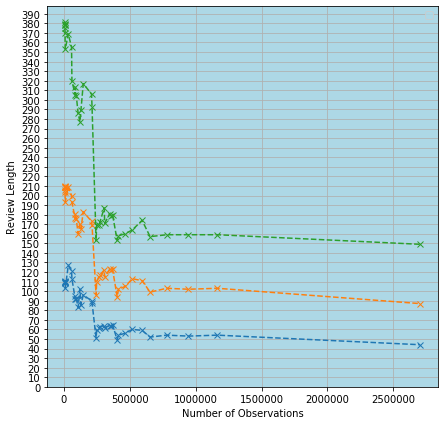

,"[0, 35)"
count,"359,387"
mean,142
std,112
min,1
25%,64
50%,122
75%,179
max,"1,977"
,"[35, 60)"
count,"309,850"


In [5]:
from student_voices import visuals as vs 

tables = []
for rng in ranges: 
    # setup the summary stat table, format into thousands and append to the list of descriptive tables 
    t = pd.DataFrame(data.loc[range_indices[rng],'Review_Length'].describe().astype(int)).rename(columns={'Review_Length':rng})
    t[rng] = t[rng].apply(lambda x: "{:,}".format(x))
    tables.append(t)

for k in label_dict: 
    for v in label_dict[k]: 
        if v != 5: 
            t = pd.DataFrame(data.loc[label_dict[k][v],'Review_Length'].describe().astype(int)).rename(columns={'Review_Length':k+': '+str(int(v))})
            t[k+': '+str(int(v))] = t[k+': '+str(int(v))].apply(lambda x: "{:,}".format(x))
            tables.append(t)

vs.chart_review_lengths(tables, save='C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices/graphs/review length percentile distributions.png')
vs.display_side_by_side(tables)

* Reviewing the distribution of review lengths above there is a clear correlation between corpus size and review length which is curious since the corpus are determined based on fairly arbitrary characteristics (rating & corpus size) and not statistical parameters. 

* Most of the corpus with fewer (but longer) reviews are those with low ratings on teacher characteristics (to add perspective, this sentence was 105 characters long). Interestingly, the lowest rated comments were right skewed, meaning most 

* This finding suggest that high ratings are a sort of "default" while lower ratings will tend to be more informative (keep in mind we do not say anything about whether these describe teachers more accurately as there is no way to verify that).  

**Setting review length:** We use the summary statistics above to set different minima for review length in the page. 

**# of Topics to Try:** We need a manageable ammount of topics. Since there are 13 characteristics highlighted by the website, 3 of which have been present since the beginning of data collection, iterate between 3 and 30 topics. 

In [11]:
from student_voices import lda_analysis

lda_parameters = lda_analysis.hardcoded_lda_parameters(ranges, range_indices)

Available Cores: 7


### Model Selection by Topic Coherence 

We will use topic coherence for model selection. Topic coherence measures summarize the "interpretability" of the topics resulting from a particular training model. These measures are relative, in other words they are used to compare models to one another rather than evaluate the "absolute" coherence of topics. 

A good explanation of how these measures work can be found [here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) but basically, these measures look at the similarity of words within topics, the similarity between topis, and then combines these factors into an aggregate measure. The intuition being that by increasing consistency within topics and minimizing redundancy across topics yield more human-interpretable results. 

There are several different coherence measures, we will be using the "c_v" measure which was found to out-perform other measures in the paper ["Exploring the Space of Topic Coherence Measures"](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). If time (and computing power) permits, we will also use the "c_w2v" measure which has been [shown](https://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) to reduce the noise in the estimation of the "c_v" by using Word2Vec embeddings to implicitly factorize the distance matrices required to calculate the measure. 

**Using AWS:**

In [9]:
# Instance type 
instance_type = 'r5.2xlarge'

# Number of instances to run 
n_jobs = 1

# Number of physical cores in the instance type 
n_cores = 4

# File system to connect to 
filesystem = 'student_data'

# Region
region='us-east-2'

In [2]:
from spot_connect import instance_manager

# Use the LinkAWS to move data and run jobs on AWS 
aws_link = instance_manager.InstanceManager()

Default key-pair directory is "C:/Projects/VirtualMachines/Key_Pairs"


In [6]:
from student_voices import ec2_scripts 
from spot_connect import bash_scripts

configs = ['A1']#,'B1','D1','E1']
settings = ['LDA1']#,'LDA2','LDA3','LDA4']

n_jobs = len(configs)*len(settings) # number of instances we'll run 

model_dir = '/home/ec2-user/efs/models/'
config_path = '/home/ec2-user/efs/data/cleaned_data/'

scripts = [] 
uploads = [] 
for config in configs: 
    for setting in settings:     
        script = ec2_scripts.get_instance_setup_script(
            filesystem,
            region,
            run_as_user='ec2-user')

        log_file_name = '/efs/models/log_'+str(setting)+'_'+str(config)+'.txt'

        script = ec2_scripts.get_lda_script(
            config,
            setting,
            model_dir,
            config_path,
            log_file_name,
            region='us-east-2', 
            cancel_fleet=False,
            run_as_user='ec2-user',
            script=script) 

    # Convert the working script to base-64 encoded so the fleet can run it 
    user_data_script = bash_scripts.script_to_userdata(script)

    scripts.append(user_data_script)

...EFS file system already exists
Waiting for availability......Available


In [8]:
print(n_jobs)
#print(script)

1


In [7]:
account_number_file = 'C:/Users/Computer/Documents/AWS/account_number.txt'
account_num = open(account_number_file).read()
        
aws_link.run_distributed_jobs(account_num,
                              'lda_analysis_',            # Instance prefix 
                              n_jobs,                             # Number of jobs 
                              instance_type,                      # Instance type to use
                              availability_zone='us-east-2c',
                              user_data=scripts,                  # List of scripts, 1 for each job 
                              instance_profile='instance_manager') 

Key pair detected, re-using...
Security group detected, re-using...
